## Geoscripting Exercise 12
### Team Chantalle_Tom
### Date: 23-01-2018

#### Step 1: import the modules that will be used for this exercise.
NOTE: please install modules first, for example by running "conda install urllib" and "conda install matplotlib" in the Bash shell.

In [11]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib
import shutil
import tarfile

#### Step 2: create the working directories "data" and "output".

In [12]:
try:
    os.stat("data")
except:
    os.mkdir("data")
try:
    os.stat("output")
except:
    os.mkdir("output")

#### Step 3: download and untar the data from dropbox.

In [13]:
url = 'https://www.dropbox.com/s/zb7nrla6fqi1mq4/LC81980242014260-SC20150123044700.tar.gz?dl=1'
file = 'data/Landsat.tar.gz'
with urllib.request.urlopen(url) as response, open(file, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

tar = tarfile.open("data/Landsat.tar.gz")
tar.extractall('./data/Landsat')
tar.close()

#### Step 4: open datasource, read data into arrays and set value type to float.

In [14]:
band3 = "data/Landsat/LC81980242014260LGN00_sr_band3.tif"
band5 = "data/Landsat/LC81980242014260LGN00_sr_band5.tif"

dataSource3 = gdal.Open(band3, GA_ReadOnly)
dataSource5 = gdal.Open(band5, GA_ReadOnly)

band3Arr = dataSource3.ReadAsArray(0,0,dataSource3.RasterXSize, dataSource3.RasterYSize)
band5Arr = dataSource5.ReadAsArray(0,0,dataSource5.RasterXSize, dataSource5.RasterYSize)

band3Arr = band3Arr.astype(np.float32)
band5Arr = band5Arr.astype(np.float32)

#### Step 5: define a function to mask out -9999 values, and to calculate the NDWI.

In [15]:
def NDWI(band3, band5):
    mask = np.greater(band5 + band3, 0)
    with np.errstate(invalid = 'ignore'):
        ndwi = np.choose(mask,(np.float(-9999), (band5 - band3) / (band5 + band3)))
    return ndwi

#### Step 6: call the NDWI function to create a new raster layer containing the NDWI values, and print its min and max values.

In [16]:
NDWILandsat = NDWI(band3Arr, band5Arr)
print("The min and max values of the new raster file are:", NDWILandsat[NDWILandsat > -9999].min(), "and", NDWILandsat.max())

The min and max values of the new raster file are: -6.4347825 and 5.283988


#### Step 7: write result to disk, set projection and extents and save it.

In [17]:
driver = gdal.GetDriverByName('GTiff')
outDataSet=driver.Create('./output/NDWILandsat.tif', dataSource5.RasterXSize, dataSource5.RasterYSize, 1, GDT_Float32)
outBand = outDataSet.GetRasterBand(1)
outBand.WriteArray(NDWILandsat, 0, 0)
outBand.SetNoDataValue(-9999)

outDataSet.SetProjection(dataSource5.GetProjection())
outDataSet.SetGeoTransform(dataSource5.GetGeoTransform())

outBand.FlushCache()
outDataSet.FlushCache()

#### Step 8: reproject the file to WGS84 (via Bash)

In [18]:
!gdalwarp -t_srs "EPSG:4326" output/NDWILandsat.tif output/NDWILandsatWGS84.tif

Processing input file output/NDWILandsat.tif.
Using internal nodata values (e.g. -9999) for image output/NDWILandsat.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


#### Step 9: plot the results: by opening the image (dsll), reading the data, plotting it, and reset the dsll again.

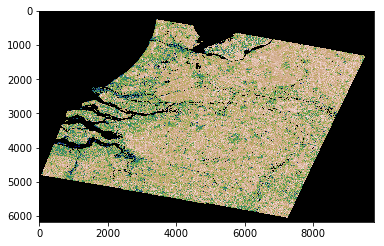

In [19]:
dsll = gdal.Open("./output/NDWILandsatWGS84.tif")

NDWI = dsll.ReadAsArray(0, 0, dsll.RasterXSize, dsll.RasterYSize)

plt.imshow(NDWI, interpolation = 'nearest', vmin = 0, cmap = plt.cm.gist_earth)
plt.show()

dsll = None